In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

# training
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# test
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print('train: ', trainset.data.shape)
print('test: ', testset.data.shape)

train:  (50000, 32, 32, 3)
test:  (10000, 32, 32, 3)


In [4]:
classes = trainset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(3, 36, 138)
(36, 138, 3)


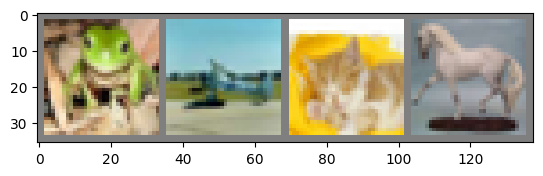

 frog airplane   cat horse


In [6]:
def imshow(img):
    img = img / 2 + 0.5
    print(type(img))
    npimg = img.numpy()
    print(type(npimg))
    print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    print(npimg.shape)
    plt.imshow(npimg)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [8]:
# 交差エントロピー
criterion = nn.CrossEntropyLoss()
# 確率的勾配降下法
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.181
[1,  4000] loss: 1.850
[1,  6000] loss: 1.688
[1,  8000] loss: 1.590
[1, 10000] loss: 1.519
[1, 12000] loss: 1.464
[2,  2000] loss: 1.387
[2,  4000] loss: 1.356
[2,  6000] loss: 1.330
[2,  8000] loss: 1.311
[2, 10000] loss: 1.284
[2, 12000] loss: 1.251
Finished Training


In [10]:
PATH = '../models/cnn_tutorial.pth'
torch.save(net.state_dict(), PATH)

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(3, 36, 138)
(36, 138, 3)


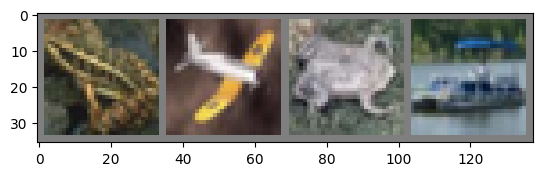

GroundTruth:   frog airplane  frog  ship
Predicted:   frog horse truck automobile


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [13]:
print(outputs)
value, predicted = torch.max(outputs, 1)
print(value)
print(predicted)

tensor([[-2.1963e+00, -2.7905e+00,  2.3271e+00,  5.9979e-01,  2.9610e+00,
          1.0145e+00,  5.4800e+00, -9.8964e-01, -4.3027e+00, -2.2887e+00],
        [ 2.9653e-01, -5.9363e-01,  7.9192e-01,  2.6726e-01,  3.1816e-01,
          2.3811e-01,  9.5309e-01,  1.1500e+00, -1.6643e+00, -1.0570e+00],
        [ 3.6730e-01, -9.0106e-02, -5.1700e-01, -2.5364e-02, -3.7998e-03,
         -2.0888e-01, -5.3488e-01, -1.8835e-02, -2.0651e-01,  1.4534e+00],
        [ 1.8499e+00,  3.1672e+00, -1.0147e+00, -9.6287e-01, -8.4510e-01,
         -1.8067e+00, -1.0097e+00, -2.5365e+00,  2.2366e+00,  1.2891e+00]],
       grad_fn=<AddmmBackward0>)
tensor([5.4800, 1.1500, 1.4534, 3.1672], grad_fn=<MaxBackward0>)
tensor([6, 7, 9, 1])


In [14]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %
